<a href="https://colab.research.google.com/github/ParkJJHH/schoolPro/blob/main/PyTorch_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0.빠른 시작

## 데이터 작업하기

> 데이터 작업을 위한 기본 요소 두가지

torch.utils.data.DataLoader

torch.utils.data.Dataset

Dataset 은 샘플과 정답(label)을 저장하고, DataLoader 는 Dataset 을 순회 가능한 객체(iterable)로 감싼다.

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

torchvision.datasets 모듈은 CIFAR, COCO 등과 같은 다양한 실제 비전(vision) 데이터에 대한 Dataset을 포함하고 있다. 이 튜토리얼에서는 FasionMNIST 데이터셋을 사용

In [ ]:
# 공개 데이터셋에서 학습 데이터를 내려받습니다.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# 공개 데이터셋에서 테스트 데이터를 내려받습니다.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

Dataset 을 DataLoader 의 인자로 전달한다. 이는 데이터셋을 순회 가능한 객체(iterable)로 감싸고, 자동화된 배치(batch), 샘플링(sampling), 섞기(shuffle) 및 다중 프로세스로 데이터 불러오기(multiprocess data loading)를 지원한다. 여기서는 배치 크기(batch size)를 64로 정의한다. 즉, 데이터로더(dataloader) 객체의 각 요소는 64개의 특징(feature)과 정답(label)을 묶음(batch)으로 반환한다.

In [ ]:
batch_size = 64

# 데이터로더를 생성합니다.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64




---



## 모델 만들기

PyTorch에서 신경망 모델은 nn.Module 을 상속받는 클래스(class)를 생성하여 정의한다. __init__ 함수에서 신경망의 계층(layer)들을 정의하고 forward 함수에서 신경망에 데이터를 어떻게 전달할지 지정한다. 가능한 경우 GPU로 신경망을 이동시켜 연산을 가속(accelerate)한다.

In [ ]:
# 학습에 사용할 CPU나 GPU 장치를 얻습니다.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# 모델을 정의합니다.
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)




---



## 모델 매개변수 최적화하기

델을 학습하려면 손실 함수(loss function) 와 옵티마이저(optimizer) 가 필요

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

각 학습 단계(training loop)에서 모델은 (배치(batch)로 제공되는) 학습 데이터셋에 대한 예측을 수행하고, 예측 오류를 역전파하여 모델의 매개변수를 조정

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # 예측 오류 계산
        pred = model(X)
        loss = loss_fn(pred, y)

        # 역전파
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

학습 단계는 여러번의 반복 단계 (에폭(epochs)) 를 거쳐서 수행된다. 각 에폭에서는 모델은 더 나은 예측을 하기 위해 매개변수를 학습한다. 각 에폭마다 모델의 정확도(accuracy)와 손실(loss)을 출력한다; 에폭마다 정확도가 증가하고 손실이 감소하는 것을 확인한다.

In [ ]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.299730  [    0/60000]
loss: 2.291341  [ 6400/60000]
loss: 2.274522  [12800/60000]
loss: 2.275568  [19200/60000]
loss: 2.237488  [25600/60000]
loss: 2.223000  [32000/60000]
loss: 2.227885  [38400/60000]
loss: 2.192380  [44800/60000]
loss: 2.191580  [51200/60000]
loss: 2.166183  [57600/60000]
Test Error: 
 Accuracy: 44.8%, Avg loss: 2.155251 

Epoch 2
-------------------------------
loss: 2.171917  [    0/60000]
loss: 2.154410  [ 6400/60000]
loss: 2.101138  [12800/60000]
loss: 2.119461  [19200/60000]
loss: 2.038335  [25600/60000]
loss: 2.004910  [32000/60000]
loss: 2.025089  [38400/60000]
loss: 1.946552  [44800/60000]
loss: 1.963472  [51200/60000]
loss: 1.887447  [57600/60000]
Test Error: 
 Accuracy: 52.8%, Avg loss: 1.880362 

Epoch 3
-------------------------------
loss: 1.933565  [    0/60000]
loss: 1.884882  [ 6400/60000]
loss: 1.777013  [12800/60000]
loss: 1.815575  [19200/60000]
loss: 1.667556  [25600/60000]
loss: 1.660512  [32000/600



---



## 모델 저장하기

모델을 저장하는 일반적인 방법은 (모델의 매개변수들을 포함하여) 내부 상태 사전(internal state dictionary)을 직렬화(serialize)하는 것

In [ ]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


## 모델 불러오기

모델을 불러오는 과정에는 모델 구조를 다시 만들고 상태 사전을 모델에 불러오는 과정이 포함

In [ ]:
model = NeuralNetwork()
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

In [ ]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


# 1.텐서(Tensor)

텐서(tensor)는 배열(array)이나 행렬(matrix)과 매우 유사한 특수한 자료구조이다. PyTorch에서는 텐서를 사용하여 모델의 입력(input)과 출력(output), 그리고 모델의 매개변수들을 부호화(encode)한다.

In [ ]:
import torch
import numpy as np

## 텐서 초기화

**데이터로부터 직접(directly) 생성하기**

데이터로부터 직접 텐서를 생성할 수 있습니다. 데이터의 자료형(data type)은 자동으로 유추

In [ ]:
data = [[1, 2],[3, 4]]
x_data = torch.tensor(data)

**NumPy 배열로부터 생성하기**

텐서는 NumPy 배열로 생성할 수 있다. (그 반대도 가능)

In [ ]:
np_array = np.array(data)
x_np = torch.from_numpy(np_array)

**다른 텐서로부터 생성하기:**

명시적으로 재정의(override)하지 않는다면, 인자로 주어진 텐서의 속성(모양(shape), 자료형(datatype))을 유지

In [ ]:
x_ones = torch.ones_like(x_data) # x_data의 속성을 유지합니다.
print(f"Ones Tensor: \n {x_ones} \n")

x_rand = torch.rand_like(x_data, dtype=torch.float) # x_data의 속성을 덮어씁니다.
print(f"Random Tensor: \n {x_rand} \n")

Ones Tensor: 
 tensor([[1, 1],
        [1, 1]]) 

Random Tensor: 
 tensor([[0.5213, 0.5776],
        [0.5325, 0.7001]]) 



**무작위(random) 또는 상수(constant) 값을 사용하기:**

shape 은 텐서의 차원(dimension)을 나타내는 튜플(tuple)로, 아래 함수들에서는 출력 텐서의 차원을 결정

In [ ]:
shape = (2,3,)
rand_tensor = torch.rand(shape)
ones_tensor = torch.ones(shape)
zeros_tensor = torch.zeros(shape)

print(f"Random Tensor: \n {rand_tensor} \n")
print(f"Ones Tensor: \n {ones_tensor} \n")
print(f"Zeros Tensor: \n {zeros_tensor}")

Random Tensor: 
 tensor([[0.0912, 0.6091, 0.1654],
        [0.2489, 0.5076, 0.1714]]) 

Ones Tensor: 
 tensor([[1., 1., 1.],
        [1., 1., 1.]]) 

Zeros Tensor: 
 tensor([[0., 0., 0.],
        [0., 0., 0.]])




---



## 텐서의 속성(Attribute)

텐서의 속성은 텐서의 모양(shape), 자료형(datatype) 및 어느 장치에 저장되는지를 나타낸다.

In [ ]:
tensor = torch.rand(3,4)

print(f"Shape of tensor: {tensor.shape}")
print(f"Datatype of tensor: {tensor.dtype}")
print(f"Device tensor is stored on: {tensor.device}")

Shape of tensor: torch.Size([3, 4])
Datatype of tensor: torch.float32
Device tensor is stored on: cpu




---



## 텐서 연산(Operation)

In [ ]:
# GPU가 존재하면 텐서를 이동합니다
if torch.cuda.is_available():
    tensor = tensor.to("cuda")

**NumPy식의 표준 인덱싱과 슬라이싱:**

In [ ]:
tensor = torch.ones(4, 4)
print(f"First row: {tensor[0]}")
print(f"First column: {tensor[:, 0]}")
print(f"Last column: {tensor[..., -1]}")
tensor[:,1] = 0
print(tensor)

First row: tensor([1., 1., 1., 1.])
First column: tensor([1., 1., 1., 1.])
Last column: tensor([1., 1., 1., 1.])
tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])


텐서 합치기 torch.cat 을 사용하여 주어진 차원에 따라 일련의 텐서를 연결할 수 있다.

In [ ]:
t1 = torch.cat([tensor, tensor, tensor], dim=1)
print(t1)

tensor([[1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.]])


**산술 연산(Arithmetic operations)**

In [ ]:
# 두 텐서 간의 행렬 곱(matrix multiplication)을 계산합니다. y1, y2, y3은 모두 같은 값을 갖습니다.
y1 = tensor @ tensor.T
y2 = tensor.matmul(tensor.T)

y3 = torch.rand_like(y1)
torch.matmul(tensor, tensor.T, out=y3)


# 요소별 곱(element-wise product)을 계산합니다. z1, z2, z3는 모두 같은 값을 갖습니다.
z1 = tensor * tensor
z2 = tensor.mul(tensor)

z3 = torch.rand_like(tensor)
torch.mul(tensor, tensor, out=z3)

tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])

**단일-요소(single-element) 텐서** 텐서의 모든 값을 하나로 집계(aggregate)하여 요소가 하나인 텐서의 경우, item() 을 사용하여 Python 숫자 값으로 변환할 수 있다:

In [ ]:
agg = tensor.sum()
agg_item = agg.item()
print(agg_item, type(agg_item))

12.0 <class 'float'>


**바꿔치기(in-place) 연산** 연산 결과를 피연산자(operand)에 저장하는 연산을 바꿔치기 연산이라고 부르며, _ 접미사를 갖는다. 예를 들어: x.copy_(y) 나 x.t_() 는 x 를 변경한다.

In [ ]:
print(f"{tensor} \n")
tensor.add_(5)
print(tensor)

tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]]) 

tensor([[6., 5., 6., 6.],
        [6., 5., 6., 6.],
        [6., 5., 6., 6.],
        [6., 5., 6., 6.]])


** 바꿔치기 연산은 메모리를 일부 절약하지만, 기록(history)이 즉시 삭제되어 도함수(derivative) 계산에 문제가 발생할 수 있으므로 사용을 권장하지 않는다.



---



## NumPy 변환(Bridge)

CPU 상의 텐서와 NumPy 배열은 메모리 공간을 공유하기 때문에, 하나를 변경하면 다른 하나도 변경된다.

### 텐서를 NumPy 배열로 변환하기

In [ ]:
t = torch.ones(5)
print(f"t: {t}")
n = t.numpy()
print(f"n: {n}")

t: tensor([1., 1., 1., 1., 1.])
n: [1. 1. 1. 1. 1.]


텐서의 변경 사항이 NumPy 배열에 반영

In [ ]:
t.add_(1)
print(f"t: {t}")
print(f"n: {n}")

t: tensor([2., 2., 2., 2., 2.])
n: [2. 2. 2. 2. 2.]


### NumPy 배열을 텐서로 변환하기

In [ ]:
n = np.ones(5)
t = torch.from_numpy(n)

NumPy 배열의 변경 사항이 텐서에 반영

In [ ]:
np.add(n, 1, out=n)
print(f"t: {t}")
print(f"n: {n}")

t: tensor([2., 2., 2., 2., 2.], dtype=torch.float64)
n: [2. 2. 2. 2. 2.]


# 2.DATASET과 DATALOADER

더 나은 가독성(readability)과 모듈성(modularity)을 위해 데이터셋 코드를 모델 학습 코드로부터 분리하는 것이 이상적이다. PyTorch는 torch.utils.data.DataLoader 와 torch.utils.data.Dataset 의 두 가지 데이터 기본 요소를 제공하여 미리 준비해둔(pre-loaded) 데이터셋 뿐만 아니라 가지고 있는 데이터를 사용할 수 있도록 한다. Dataset 은 샘플과 정답(label)을 저장하고, DataLoader 는 Dataset 을 샘플에 쉽게 접근할 수 있도록 순회 가능한 객체(iterable)로 감싼다.

PyTorch의 도메인 특화 라이브러리들은 (FashionMNIST와 같은) 미리 준비해둔(pre-loaded) 다양한 데이터셋을 제공한다. 데이터셋은 torch.utils.data.Dataset 의 하위 클래스로 개별 데이터를 특정하는 함수가 구현되어 있다. 이러한 데이터셋은 모델을 만들어보고(prototype) 성능을 측정(benchmark)하는데 사용할 수 있다.

## 데이터셋 불러오기

TorchVision 에서 Fashion-MNIST 데이터셋을 불러오는 예제

 Fashion-MNIST는 Zalando의 기사 이미지 데이터셋으로 60,000개의 학습 예제와 10,000개의 테스트 예제로 이루어져 있다. 각 예제는 흑백(grayscale)의 28x28 이미지와 10개 분류(class) 중 하나인 정답(label)으로 구성된다.

다음 매개변수들을 사용하여 FashionMNIST 데이터셋 을 불러옵니다:
root 는 학습/테스트 데이터가 저장되는 경로이다.

* train 은 학습용 또는 테스트용 데이터셋 여부를 지정

* download=True 는 root 에 데이터가 없는 경우 인터넷에서 다운로드

* transform 과 target_transform 은 특징(feature)과 정답(label) 변형(transform)을 지정

In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

## 데이터셋을 순회하고 시각화하기

Dataset 에 리스트(list)처럼 직접 접근(index)할 수 있다: training_data[index]. matplotlib 을 사용하여 학습 데이터의 일부를 시각화.

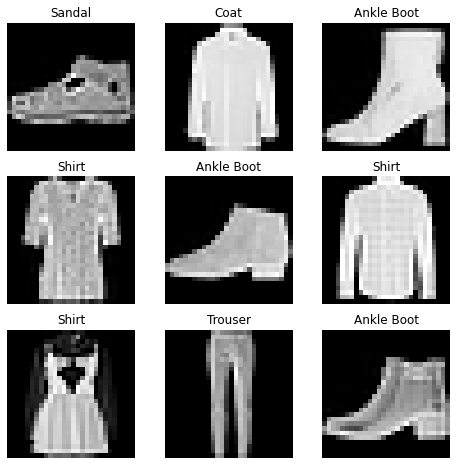

In [ ]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()



---



## 파일에서 사용자 정의 데이터셋 만들기

사용자 정의 Dataset 클래스는 반드시 3개 함수를 구현해야 한다: ___int__, __len__, and __getitem__ (아래 구현을 살펴보면 FashionMNIST 이미지들은 img_dir 디렉토리에 저장되고, 정답은 annotations_file csv 파일에 별도로 저장)

In [ ]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file, names=['file_name', 'label'])
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

### __init__

__init__ 함수는 Dataset 객체가 생성(instantiate)될 때 한 번만 실행된다. 여기서는 이미지와 주석 파일(annotation_file)이 포함된 디렉토리와 (다음 장에서 자세히 살펴볼) 두가지 변형(transform)을 초기화한다.

labels.csv 파일

In [ ]:
tshirt1.jpg, 0
tshirt2.jpg, 0
......
ankleboot999.jpg, 9

SyntaxError: ignored

In [ ]:
def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
    self.img_labels = pd.read_csv(annotations_file)
    self.img_dir = img_dir
    self.transform = transform
    self.target_transform = target_transform

### __len__

__len__ 함수는 데이터셋의 샘플 개수를 반환

In [ ]:
def __len__(self):
    return len(self.img_labels)

### __getitem__

__getitem__ 함수는 주어진 인덱스 idx 에 해당하는 샘플을 데이터셋에서 불러오고 반환한다. 인덱스를 기반으로, 디스크에서 이미지의 위치를 식별하고, read_image 를 사용하여 이미지를 텐서로 변환하고, self.img_labels 의 csv 데이터로부터 해당하는 정답(label)을 가져오고, (해당하는 경우) 변형(transform) 함수들을 호출한 뒤, 텐서 이미지와 라벨을 Python 사전(dict)형으로 반환한다.

In [ ]:
def __getitem__(self, idx):
    img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
    image = read_image(img_path)
    label = self.img_labels.iloc[idx, 1]
    if self.transform:
        image = self.transform(image)
    if self.target_transform:
        label = self.target_transform(label)
    sample = {"image": image, "label": label}
    return sample



---



## DataLoader로 학습용 데이터 준비하기

Dataset 은 데이터셋의 특징(feature)을 가져오고 하나의 샘플에 정답(label)을 지정하는 일을 한 번에 한다. 모델을 학습할 때, 일반적으로 샘플들을 “미니배치(minibatch)”로 전달하고, 매 에폭(epoch)마다 데이터를 다시 섞어서 과적합(overfit)을 막고, Python의 multiprocessing 을 사용하여 데이터 검색 속도를 높이려고 한다.

DataLoader 는 간단한 API로 이러한 복잡한 과정들을 추상화한 순회 가능한 객체(iterable)이다.

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

##DataLoader를 통해 순회하기(iterate)

DataLoader 에 데이터셋을 불러온 뒤에는 필요에 따라 데이터셋을 순회(iterate)할 수 있다. 아래의 각 순회(iteration)는 (각각 batch_size=64 의 특징(feature)과 정답(label)을 포함하는) train_features 와 train_labels 의 묶음(batch)을 반환한다. shuffle=True 로 지정했으므로, 모든 배치를 순회한 뒤 데이터가 섞인다. 

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


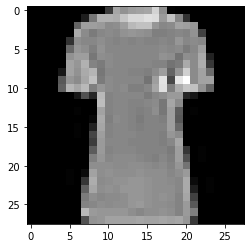

Label: 0


In [ ]:
# 이미지와 정답(label)을 표시합니다.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

# 3.변형(TRANSFORM)

학습을 하려면 정규화(normalize)된 텐서 형태의 특징(feature)과 원-핫(one-hot)으로 부호화(encode)된 텐서 형태의 정답(label)이 필요하다. 이러한 변형(transformation)을 하기 위해 ToTensor 와 Lambda 를 사용한다.

In [ ]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

ds = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

## ToTensor()

ToTensor 는 PIL Image나 NumPy ndarray 를 FloatTensor 로 변환하고, 이미지의 픽셀의 크기(intensity) 값을 [0., 1.] 범위로 비례하여 조정(scale)한다.

## Lambda 변형(Transform)

Lambda 변형은 사용자 정의 람다(lambda) 함수를 적용합니다. 여기에서는 정수를 원-핫으로 부호화된 텐서로 바꾸는 함수를 정의한다. 이 함수는 먼저 (데이터셋 정답의 개수인) 크기 10짜리 영 텐서(zero tensor)를 만들고, scatter_ 를 호출하여 주어진 정답 y 에 해당하는 인덱스에 value=1 을 할당한다.

In [ ]:
target_transform = Lambda(lambda y: torch.zeros(
    10, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1))

# 4.신경망 모델 구성하기

신경망은 데이터에 대한 연산을 수행하는 계층(layer)/모듈(module)로 구성되어 있다. torch.nn 네임스페이스는 신경망을 구성하는데 필요한 모든 구성 요소를 제공한다. PyTorch의 모든 모듈은 nn.Module 의 하위 클래스(subclass) 이다. 신경망은 다른 모듈(계층; layer)로 구성된 모듈이다. 이러한 중첩된 구조는 복잡한 아키텍처를 쉽게 구축하고 관리할 수 있다.

In [ ]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

## 학습을 위한 장치 얻기

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


가능한 경우 GPU와 같은 하드웨어 가속기에서 모델을 학습하려 한다. torch.cuda 를 사용할 수 있는지 확인하고 그렇지 않으면 CPU를 계속 사용한다.

## 클래스 정의하기

신경망 모델을 nn.Module 의 하위클래스로 정의하고, __init__ 에서 신경망 계층들을 초기화

nn.Module 을 상속받은 모든 클래스는 forward 메소드에 입력 데이터에 대한 연산들을 구현

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

NeuralNetwork 의 인스턴스(instance)를 생성하고 이를 device 로 이동한 뒤, 구조(structure)를 출력

In [ ]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


모델을 사용하기 위해 입력 데이터를 전달한다. 이는 일부 백그라운드 연산들 과 함께 모델의 forward 를 실행한다.(model.forward() 를 직접 호출하지 말 것)

모델에 입력을 호출하면 각 분류(class)에 대한 원시(raw) 예측값이 있는 10-차원 텐서가 반환된다. 원시 예측값을 nn.Softmax 모듈의 인스턴스에 통과시켜 예측 확률을 얻는다.

In [ ]:
X = torch.rand(1, 28, 28, device=device)
logits = model(X)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

Predicted class: tensor([9])




---



## 모델 계층(Layer)

FashionMNIST 모델의 계층들을 살펴본다.

이를 설명하기 위해, 28x28 크기의 이미지 3개로 구성된 미니배치를 가져와, 신경망을 통과할 때 어떤 일이 발생하는지 알아본다.



In [ ]:
input_image = torch.rand(3,28,28)
print(input_image.size())

torch.Size([3, 28, 28])


## nn.Flatten

nn.Flatten 계층을 초기화하여 각 28x28의 2D 이미지를 784 픽셀 값을 갖는 연속된 배열로 변환 (dim=0의 미니배치 차원은 유지)

In [ ]:
flatten = nn.Flatten()
flat_image = flatten(input_image)
print(flat_image.size())

torch.Size([3, 784])


## nn.Linear

선형 계층 은 저장된 가중치(weight)와 편향(bias)을 사용하여 입력에 선형 변환(linear transformation)을 적용하는 모듈

In [ ]:
layer1 = nn.Linear(in_features=28*28, out_features=20)
hidden1 = layer1(flat_image)
print(hidden1.size())

torch.Size([3, 20])


## nn.ReLU

이 모델에서는 nn.ReLU 를 선형 계층들 사이에 사용하지만, 모델을 만들 때는 비선형성을 가진 다른 활성화를 도입할 수도 있다.

In [ ]:
print(f"Before ReLU: {hidden1}\n\n")
hidden1 = nn.ReLU()(hidden1)
print(f"After ReLU: {hidden1}")

Before ReLU: tensor([[ 0.4755, -0.6681,  0.8786, -0.4078, -0.1554, -0.4503, -0.4385,  0.3397,
         -0.0311,  0.9596,  0.0665, -0.4736, -0.1852,  0.2739, -0.1654, -0.0482,
          0.0836, -0.1636, -0.0941,  0.1246],
        [ 0.4496, -0.3924,  0.8740, -0.0526, -0.2919, -0.3859, -0.0443,  0.0413,
          0.2645,  0.5377,  0.3785, -0.4973, -0.1338,  0.2183, -0.1965, -0.2852,
          0.0297, -0.1850, -0.2866,  0.0941],
        [ 0.7910, -0.8913,  0.4595, -0.4746, -0.3855, -0.1840, -0.5431,  0.1731,
         -0.1110,  0.5263, -0.0653, -0.4091, -0.2007,  0.4970, -0.5955,  0.0017,
         -0.1319, -0.3318, -0.2487,  0.0867]], grad_fn=<AddmmBackward0>)


After ReLU: tensor([[0.4755, 0.0000, 0.8786, 0.0000, 0.0000, 0.0000, 0.0000, 0.3397, 0.0000,
         0.9596, 0.0665, 0.0000, 0.0000, 0.2739, 0.0000, 0.0000, 0.0836, 0.0000,
         0.0000, 0.1246],
        [0.4496, 0.0000, 0.8740, 0.0000, 0.0000, 0.0000, 0.0000, 0.0413, 0.2645,
         0.5377, 0.3785, 0.0000, 0.0000, 0.2183, 0.00

## nn.Sequential

nn.Sequential 은 순서를 갖는 모듈의 컨테이너입니다. 데이터는 정의된 것과 같은 순서로 모든 모듈들을 통해 전달된다. 순차 컨테이너(sequential container)를 사용하여 아래의 seq_modules 와 같은 신경망을 빠르게 만들 수 있다.

In [ ]:
seq_modules = nn.Sequential(
    flatten,
    layer1,
    nn.ReLU(),
    nn.Linear(20, 10)
)
input_image = torch.rand(3,28,28)
logits = seq_modules(input_image)

nn.Softmax

신경망의 마지막 선형 계층은 nn.Softmax 모듈에 전달될 ([-infty, infty] 범위의 원시 값(raw value)인) logits 를 반환 

logits는 모델의 각 분류(class)에 대한 예측 확률을 나타내도록 [0, 1] 범위로 비례하여 조정(scale)됩니다. dim 매개변수는 값의 합이 1이 되는 차원을 나타낸다.

In [ ]:
softmax = nn.Softmax(dim=1)
pred_probab = softmax(logits)

## 모델 매개변수

신경망 내부의 많은 계층들은 매개변수화(parameterize) 된다.

즉, 학습 중에 최적화되는 가중치와 편향과 연관지어집니다. nn.Module 을 상속하면 모델 객체 내부의 모든 필드들이 자동으로 추적(track)되며, 모델의 parameters() 및 named_parameters() 메소드로 모든 매개변수에 접근할 수 있게 된다.

In [ ]:
print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Model structure: NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Layer: linear_relu_stack.0.weight | Size: torch.Size([512, 784]) | Values : tensor([[-0.0128,  0.0244, -0.0149,  ..., -0.0254,  0.0257,  0.0126],
        [-0.0349,  0.0266,  0.0238,  ..., -0.0117,  0.0146,  0.0003]],
       grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.0.bias | Size: torch.Size([512]) | Values : tensor([0.0322, 0.0232], grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.weight | Size: torch.Size([512, 512]) | Values : tensor([[ 0.0074,  0.0255, -0.0125,  ...,  0.0014,  0.0350, -0.0155],
        [ 0.0153,  0.0035, -0.0045,  ..., -0.0180, -0.0095,  0.0263]],
       grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.bias | Si



# 5.Autograd: TORCH.AUTOGRAD를 사용한 자동 미분

신경망을 학습할 때 가장 자주 사용되는 알고리즘은 역전파이다. 이 알고리즘에서, 매개변수(모델 가중치)는 주어진 매개변수에 대한 손실 함수의 변화도(gradient)에 따라 조정된다.


이러한 변화도를 계산하기 위해 PyTorch에는 torch.autograd라고 불리는 자동 미분 엔진이 내장되어 있다.


입력 x, 매개변수 w와 b , 그리고 일부 손실 함수가 있는 가장 간단한 단일 계층 신경망을 가정한다.

In [ ]:
import torch

x = torch.ones(5)  # input tensor
y = torch.zeros(3)  # expected output
w = torch.randn(5, 3, requires_grad=True)
b = torch.randn(3, requires_grad=True)
z = torch.matmul(x, w)+b
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)

## Tensor, Function과 연산그래프(Computational graph)

이 코드는 다음의 연산 그래프를 정의한다.

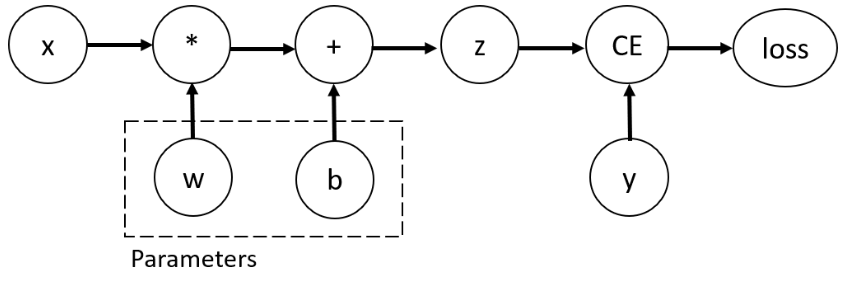

이 신경망에서, w와 b는 최적화를 해야 하는 매개변수이다. 따라서 이러한 변수들에 대한 손실 함수의 변화도를 계산할 수 있어야 한다. 이를 위해서 해당 텐서에 requires_grad 속성을 설정한다.

*requires_grad의 값은 텐서를 생성할 때 설정하거나, 나중에 x.requires_grad_(True) 메소드를 사용하여 나중에 설정할 수 있다.

연산 그래프를 구성하기 위해 텐서에 적용하는 함수는 사실 Function 클래스의 객체이다. 이 객체는 *순전파* 방향으로 함수를 계산하는 방법과, *역방향 전파* 단계에서 도함수(derivative)를 계산하는 방법을 알고 있다. 역방향 전파 함수에 대한 참조(reference)는 텐서의 grad_fn 속성에 저장된다.

In [ ]:
print(f"Gradient function for z = {z.grad_fn}")
print(f"Gradient function for loss = {loss.grad_fn}")

Gradient function for z = <AddBackward0 object at 0x7f2e170c7310>
Gradient function for loss = <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f2e170c7250>


## 변화도(Gradient) 계산하기

신경망에서 매개변수의 가중치를 최적화하려면 매개변수에 대한 손실함수의 도함수(derivative)를 계산해야 한다.

In [ ]:
loss.backward()
print(w.grad)
print(b.grad)

tensor([[0.2305, 0.1920, 0.1881],
        [0.2305, 0.1920, 0.1881],
        [0.2305, 0.1920, 0.1881],
        [0.2305, 0.1920, 0.1881],
        [0.2305, 0.1920, 0.1881]])
tensor([0.2305, 0.1920, 0.1881])


## 변화도 추적 멈추기

모델을 학습한 뒤 입력 데이터를 단순히 적용하기만 하는 경우와 같이 순전파 연산만 필요한 경우에는 연산 코드를 torch.no_grad() 블록으로 둘러싸서 연산 추적을 멈출 수 있다:

In [ ]:
z = torch.matmul(x, w)+b
print(z.requires_grad)

with torch.no_grad():
    z = torch.matmul(x, w)+b
print(z.requires_grad)

True
False


동일한 결과를 얻는 다른 방법: 텐서에 detach() 메소드를 사용하는 것

In [ ]:
z = torch.matmul(x, w)+b
z_det = z.detach()
print(z_det.requires_grad)

False


변화도 추적을 멈춰야 하는 이유


* 신경망의 일부 매개변수를 고정된 매개변수(frozen parameter)로 표시하는데, 사전 학습된 신경망을 미세조정 할 때 매우 일반적인 시나리오이다.

* 변화도를 추적하지 않는 텐서의 연산이 더 효율적이기 때문에, 순전파 단계만 수행할 때 연산 속도가 향상된다.

## 연산 그래프에 대한 추가 정보

순전파 단계에서, autograd는 다음 두 가지 작업을 동시에 수행

* 요청된 연산을 수행하여 결과 텐서를 계산하고,

* DAG에 연산의 변화도 기능(gradient function) 를 유지(maintain)

역전파 단계는 DAG 뿌리(root)에서 .backward() 가 호출될 때 시작된다. autograd는 이 때:

* 각 .grad_fn 으로부터 변화도를 계산하고,

* 각 텐서의 .grad 속성에 계산 결과를 쌓고(accumulate),

* 연쇄 법칙을 사용하여, 모든 잎(leaf) 텐서들까지 전파(propagate)

## 선택적으로 읽기(Optional Reading): 텐서 변화도와 야코비안 곱 (Jacobian Product)

대부분의 경우, 스칼라 손실 함수를 가지고 일부 매개변수와 관련한 변화도를 계산하지만 출력 함수가 임의의 텐서인 경우가 있다. 이럴 때, PyTorch는 실제 변화도가 아닌 야코비안 곱(Jacobian product)을 계산한다.

In [ ]:
inp = torch.eye(5, requires_grad=True)
out = (inp+1).pow(2)
out.backward(torch.ones_like(inp), retain_graph=True)
print(f"First call\n{inp.grad}")
out.backward(torch.ones_like(inp), retain_graph=True)
print(f"\nSecond call\n{inp.grad}")
inp.grad.zero_()
out.backward(torch.ones_like(inp), retain_graph=True)
print(f"\nCall after zeroing gradients\n{inp.grad}")

First call
tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.],
        [2., 2., 2., 2., 4.]])

Second call
tensor([[8., 4., 4., 4., 4.],
        [4., 8., 4., 4., 4.],
        [4., 4., 8., 4., 4.],
        [4., 4., 4., 8., 4.],
        [4., 4., 4., 4., 8.]])

Call after zeroing gradients
tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.],
        [2., 2., 2., 2., 4.]])


# 6.최적화(Optimization): 모델 매개변수 최적화하기

## 기본(Pre-requisite) 코드

In [ ]:
# Dataset과 DataLoader와 신경망 모델 구성하기에서 코드를 가져왔습니다.

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork()

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



## 하이퍼파라미터(Hyperparameter)

모델 최적화 과정을 제어할 수 있는 조절 가능한 매개변수

서로 다른 하이퍼파라미터 값은 모델 학습과 수렴율(convergence rate)에 영향을 미칠 수 있다.

학습 시에는 다음과 같은 하이퍼파라미터를 정의

* 에폭(epoch) 수 - 데이터셋을 반복하는 횟수

* 배치 크기(batch size) - 매개변수가 갱신되기 전 신경망을 통해 전파된 데이터 샘플의 수

* 학습률(learning rate) - 각 배치/에폭에서 모델의 매개변수를 조절하는 비율. 값이 작을수록 학습 속도가 느려지고, 값이 크면 학습 중 예측할 수 없는 동작이 발생할 수 있다.

In [ ]:
learning_rate = 1e-3
batch_size = 64
epochs = 5

## 최적화 단계(Optimization Loop)

하이퍼파라미터를 설정한 뒤에는 최적화 단계를 통해 모델을 학습하고 최적화할 수 있다. 최적화 단계의 각 반복(iteration)을 에폭이라 부른다.

에폭의 구성

* 학습 단계(train loop) - 학습용 데이터셋을 반복(iterate)하고 최적의 매개변수로 수렴

* 검증/테스트 단계(validation/test loop) - 모델 성능이 개선되고 있는지를 확인하기 위해 테스트 데이터셋을 반복(iterate)

### 손실 함수(loss function)

손실 함수(loss function)는 획득한 결과와 실제 값 사이의 틀린 정도(degree of dissimilarity)를 측정하며, 학습 중에 이 값을 최소화하려고 한다. 주어진 데이터 샘플을 입력으로 계산한 예측과 정답(label)을 비교하여 손실(loss)을 계산한다.

일반적인 손실함수에는 회귀 문제(regression task)에 사용하는 nn.MSELoss(평균 제곱 오차(MSE; Mean Square Error))나 분류(classification)에 사용하는 nn.NLLLoss (음의 로그 우도(Negative Log Likelihood)), 그리고 nn.LogSoftmax와 nn.NLLLoss를 합친 nn.CrossEntropyLoss 등이 있다.

모델의 출력 로짓(logit)을 nn.CrossEntropyLoss에 전달하여 로짓(logit)을 정규화하고 예측 오류를 계산한다.

In [ ]:
# 손실 함수를 초기화합니다.
loss_fn = nn.CrossEntropyLoss()

### 옵티마이저(Optimizer)

최적화 알고리즘은 이 과정이 수행되는 방식(여기에서는 확률적 경사하강법(SGD; Stochastic Gradient Descent))을 정의한다. 모든 최적화 절차(logic)는 optimizer 객체에 캡슐화(encapsulate)된다. 여기서는 SGD 옵티마이저를 사용하고 있으며, PyTorch에는 ADAM이나 RMSProp과 같은 다른 종류의 모델과 데이터에서 더 잘 동작하는 다양한 옵티마이저가 있다.

In [ ]:
#학습하려는 모델의 매개변수와 학습률(learning rate) 하이퍼파라미터를 등록하여 옵티마이저를 초기화합니다.

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

학습 단계(loop)에서 최적화하는 세 단계

* optimizer.zero_grad()를 호출하여 모델 매개변수의 변화도를 재설정한다. 기본적으로 변화도는 더해지기(add up) 때문에 중복 계산을 막기 위해 반복할 때마다 명시적으로 0으로 설정

* loss.backwards()를 호출하여 예측 손실(prediction loss)을 역전파한다. PyTorch는 각 매개변수에 대한 손실의 변화도를 저장

* 변화도를 계산한 뒤에는 optimizer.step()을 호출하여 역전파 단계에서 수집된 변화도로 매개변수를 조정한다.

## 전체 구현

In [ ]:
#최적화 코드를 반복하여 수행하는 train_loop와 테스트 데이터로 모델의 성능을 측정하는 test_loop를 정의하였습니다.

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # 예측(prediction)과 손실(loss) 계산
        pred = model(X)
        loss = loss_fn(pred, y)

        # 역전파
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.306584  [    0/60000]
loss: 2.300630  [ 6400/60000]
loss: 2.273491  [12800/60000]
loss: 2.262851  [19200/60000]
loss: 2.259281  [25600/60000]
loss: 2.217312  [32000/60000]
loss: 2.226429  [38400/60000]
loss: 2.196736  [44800/60000]
loss: 2.179781  [51200/60000]
loss: 2.146998  [57600/60000]
Test Error: 
 Accuracy: 41.4%, Avg loss: 2.149064 

Epoch 2
-------------------------------
loss: 2.163759  [    0/60000]
loss: 2.160990  [ 6400/60000]
loss: 2.098732  [12800/60000]
loss: 2.107898  [19200/60000]
loss: 2.065055  [25600/60000]
loss: 1.997484  [32000/60000]
loss: 2.027209  [38400/60000]
loss: 1.953233  [44800/60000]
loss: 1.940903  [51200/60000]
loss: 1.873267  [57600/60000]
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.875483 

Epoch 3
-------------------------------
loss: 1.912938  [    0/60000]
loss: 1.894825  [ 6400/60000]
loss: 1.769467  [12800/60000]
loss: 1.802891  [19200/60000]
loss: 1.694924  [25600/60000]
loss: 1.641766  [32000/600

# 7.모델 저장하고 불러오기

In [ ]:
import torch
import torchvision.models as models

## 모델 가중치 저장하고 불러오기

yTorch 모델은 학습한 매개변수를 state_dict라고 불리는 내부 상태 사전(internal state dictionary)에 저장한다. 이 상태 값들은 torch.save 메소드를 사용하여 저장(persist)할 수 있다.

In [ ]:
model = models.vgg16(pretrained=True)
torch.save(model.state_dict(), 'model_weights.pth')

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
model = models.vgg16() # 기본 가중치를 불러오지 않으므로 pretrained=True를 지정하지 않습니다.
model.load_state_dict(torch.load('model_weights.pth'))
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

*추론(inference)을 하기 전에 model.eval() 메소드를 호출하여 드롭아웃(dropout)과 배치 정규화(batch normalization)를 평가 모드(evaluation mode)로 설정해야 한다. 그렇지 않으면 일관성 없는 추론 결과가 생성된다.

## 모델의 형태를 포함하여 저장하고 불러오기

 이 클래스의 구조를 모델과 함께 저장하고 싶으면, (model.state_dict()가 아닌) model 을 저장 함수에 전달한다.

In [ ]:
torch.save(model, 'model.pth')

모델을 불러온다.

In [ ]:
model = torch.load('model.pth')